### Part 1: Data Pre-processing

```shell
!pip install -U kardiasclean
```

#### Step 1: Load Data from CSV

Load csv and merge them with pandas to create a dataframe with repeated patient data but unique surgical procedure per patient.

In [8]:
import pandas as pd
import kardiasclean
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [9]:
procedure_per_patient_df.dropna(inplace=True)

In [10]:
# load
patient_df = pd.read_csv("db_patient.csv")
procedure_per_patient_df = pd.read_csv("db_patient_diagnosis_general.csv")

In [11]:
# merge
df = pd.merge(patient_df, procedure_per_patient_df)
print(df.columns)
df[5:10]

Index(['patient_id', 'gender', 'age_days', 'weight_kg', 'height_cm',
       'cx_previous', 'date_birth', 'date_procedure', 'rachs', 'stay_days',
       'expired', 'diagnosis_general'],
      dtype='object')


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired,diagnosis_general
5,5,1,2888,34.4,134.0,0,2004-08-31,2012-08-09,2,2,0,Ninguno
6,6,0,3828,37.0,141.0,0,2002-04-02,2012-09-22,2,2,0,Ninguno
7,7,0,1583,13.5,102.0,0,2008-06-05,2012-09-29,1,2,0,Ninguno
8,8,1,3549,37.0,137.0,0,2002-04-12,2012-10-13,2,5,0,Ninguno
9,9,1,5536,62.0,162.0,0,1997-04-06,2012-10-20,1,2,0,VACTER


#### Step 2: High and Low Frequency Categories (Exploratory)

We can play with the QUANTILE variable to find a good signal to noise ratio (assuming that the low frequency values can add noise to the model). This is only so we can get an idea of how much data is binned in the next step.

In [13]:
QUANTILE = 0.85
low, high = kardiasclean.perform_frequency_split_quantile(df['diagnosis_general'], QUANTILE)
print(kardiasclean.evaluate_distribution(high, low))

Total data (repeated): 1423
--------------------
Unique high frequency data: 88
Unique low frequency data: 490
--------------------
Total high frequency data: 933
Total low frequency data: 490
--------------------
Percentage of high data: 65.57%
Percentage of low data: 34.43%
--------------------
Summary
--------------------
From 1423 data, 88 account for 65.57% of the total count.



#### Step 3: Bin Low Frequency Data

Convert all low frequency categorical variables to "Other".

In [15]:
df['diagnosis_general'] = kardiasclean.perform_binning_quantile(df['diagnosis_general'], QUANTILE)
df['diagnosis_general']

0       Ninguno
1       Ninguno
2       Ninguno
3       Ninguno
4       Ninguno
         ...   
1420      Other
1421      Other
1422      Other
1423      Other
1424      Other
Name: diagnosis_general, Length: 1425, dtype: object

#### Step 4: Deal with dates
We are going to replace the date of birth and date of procedure with a new value that will be the difference of the two so we can use it as a number in our model.

**NOTE**: The age_days and date_delta have a linear relationship so maybe we can drop one in favor of the other.

,age_days,date_delta
0,3942,3882
1,3202,3338
2,3147,3193
3,4005,3975
4,5289,5131


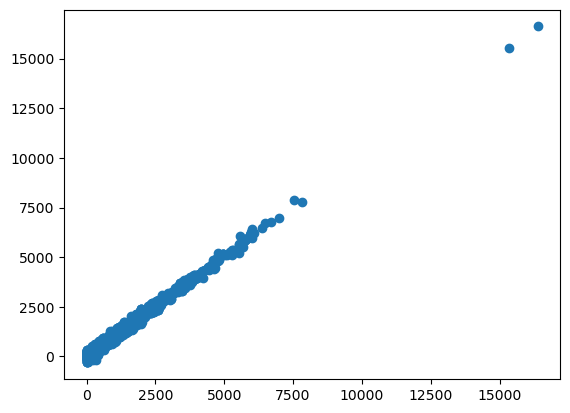

In [16]:
df['date_delta'] = (pd.to_datetime(df['date_procedure']) - pd.to_datetime(df['date_birth'])).dt.days
plt.scatter(df['age_days'], df['date_delta'])
df[0:5][['age_days', 'date_delta']]

In [17]:
# Drop unnecessary dates / ages
df = df.drop(columns=["date_birth", "date_procedure", 'age_days'])
df[5:10]

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,diagnosis_general,date_delta
5,5,1,34.4,134.0,0,2,2,0,Ninguno,2900
6,6,0,37.0,141.0,0,2,2,0,Ninguno,3826
7,7,0,13.5,102.0,0,1,2,0,Ninguno,1577
8,8,1,37.0,137.0,0,2,5,0,Ninguno,3837
9,9,1,62.0,162.0,0,1,2,0,VACTER,5676


#### Step 5: Encode Categorical Data and Merge

We are going to encode the categorical data and merge it with the original.

In [18]:
encoded = kardiasclean.perform_matrix_encoding(df['diagnosis_general'], df['patient_id'])
merged_df = pd.merge(df, encoded).drop("diagnosis_general", axis=1)
merged_df[5:10]

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,date_delta,diagnosis_general_Ninguno,...,diagnosis_general_Alteracion de la mecanica de la deglucion,diagnosis_general_PO gastrostomia,diagnosis_general_funduplicatura tipo Nissen laparoscopica 120521,diagnosis_general_Sepsis de foco urinario remitida,diagnosis_general_Sx Down,diagnosis_general_Sobrepeso,diagnosis_general_Estrabismo,diagnosis_general_Peso bajo al nacimiento Peso bajo para la edad gestacional,diagnosis_general_Conjuntivis bacteriana,diagnosis_general_Malformacion anorrectal con fistula recto vestibular
5,5,1,34.4,134.0,0,2,2,0,2900,1,...,0,0,0,0,0,0,0,0,0,0
6,6,0,37.0,141.0,0,2,2,0,3826,1,...,0,0,0,0,0,0,0,0,0,0
7,7,0,13.5,102.0,0,1,2,0,1577,1,...,0,0,0,0,0,0,0,0,0,0
8,8,1,37.0,137.0,0,2,5,0,3837,1,...,0,0,0,0,0,0,0,0,0,0
9,9,1,62.0,162.0,0,1,2,0,5676,0,...,0,0,0,0,0,0,0,0,0,0


#### Step 6: Group all Duplicated Patients
In this case, we want to group by patient_id so one row can have a 1 value in multiple categorical columns. This is optional as we could decide to not consider overlapping procedures.

In [19]:
final_df = merged_df.groupby("patient_id").mean()
print("Before merging", merged_df.shape)
print("After merging", final_df.shape)
final_df[5:10]

Before merging (1425, 99)
After merging (1003, 98)


,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,date_delta,diagnosis_general_Ninguno,diagnosis_general_VACTER,...,diagnosis_general_Alteracion de la mecanica de la deglucion,diagnosis_general_PO gastrostomia,diagnosis_general_funduplicatura tipo Nissen laparoscopica 120521,diagnosis_general_Sepsis de foco urinario remitida,diagnosis_general_Sx Down,diagnosis_general_Sobrepeso,diagnosis_general_Estrabismo,diagnosis_general_Peso bajo al nacimiento Peso bajo para la edad gestacional,diagnosis_general_Conjuntivis bacteriana,diagnosis_general_Malformacion anorrectal con fistula recto vestibular
patient_id,,,,,,,,,,,,,,,,,,,,,
5,1.0,34.4,134.0,0.0,2.0,2.0,0.0,2900.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,37.0,141.0,0.0,2.0,2.0,0.0,3826.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,13.5,102.0,0.0,1.0,2.0,0.0,1577.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,37.0,137.0,0.0,2.0,5.0,0.0,3837.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,62.0,162.0,0.0,1.0,2.0,0.0,5676.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 2: Questions and ML

We are going to use questions to pick our ML models.

#### Step 1: Target and Features

##### **Question**: Given the patient data including surgical procedures, will the patient stay more than a week in intensive care? (> 7 days)


In [22]:
# Target
y = final_df["stay_days"].map(lambda x: 1 if x > 7 else 0).values # create binary target
X = final_df.drop(["stay_days"], axis=1).values
print("Records with less than 7 days:", y[y==0].shape[0])
print("Records with more than 7 days:", y[y==1].shape[0])

Records with less than 7 days: 710
Records with more than 7 days: 293


In [23]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Normalize
scaler = StandardScaler()
X_scaler = scaler.fit(X)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape, y_train.shape

((752, 97), (752,))

#### Step 2: Neural Network
We pick a model depending on our target.

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#work-with-hyperparameters

In [24]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
dim = len(X_train_scaled[0])
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="tanh", input_dim=dim))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="linear"))
# Third hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="relu"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                5880      
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 13,261
Trainable params: 13,261
Non-trainable params: 0
_________________________________________________________________


#### Step 3: Train and Predict

We compile and fit the model. Then make a prediction.

In [25]:
# Train
optimizer = tf.keras.optimizers.Adam(0.0001) # set learning rate
# LOSS: binary_crossentropy, mean_squared_error
nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs=120, verbose=1)

Epoch 1/120
24/24 [==============================] - 5s 4ms/step - loss: 0.7466 - accuracy: 0.4082
Epoch 2/120
24/24 [==============================] - 0s 2ms/step - loss: 0.7068 - accuracy: 0.5652
Epoch 3/120
24/24 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.6769
Epoch 4/120
24/24 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.7221
Epoch 5/120
24/24 [==============================] - 0s 2ms/step - loss: 0.6265 - accuracy: 0.7207
Epoch 6/120
24/24 [==============================] - 0s 2ms/step - loss: 0.6066 - accuracy: 0.7221
Epoch 7/120
24/24 [==============================] - 0s 2ms/step - loss: 0.5886 - accuracy: 0.7247
Epoch 8/120
24/24 [==============================] - 0s 2ms/step - loss: 0.5724 - accuracy: 0.7314
Epoch 9/120
24/24 [==============================] - 0s 2ms/step - loss: 0.5582 - accuracy: 0.7380
Epoch 10/120
24/24 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.7434
Epoch 11/

24/24 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.8590
Epoch 84/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3563 - accuracy: 0.8564
Epoch 85/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3557 - accuracy: 0.8564
Epoch 86/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.8564
Epoch 87/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3545 - accuracy: 0.8564
Epoch 88/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.8564
Epoch 89/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8577
Epoch 90/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3524 - accuracy: 0.8577
Epoch 91/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8577
Epoch 92/120
24/24 [==============================] - 0s 2ms/step - loss: 0.3512 - accuracy: 0.8577
Epoch 93/120


#### Step 4: Evaluate

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#visualize-the-results

In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 1s - loss: 0.5815 - accuracy: 0.7410 - 685ms/epoch - 86ms/step
Loss: 0.5815467238426208, Accuracy: 0.7410358786582947


<AxesSubplot:title={'center':'loss'}>

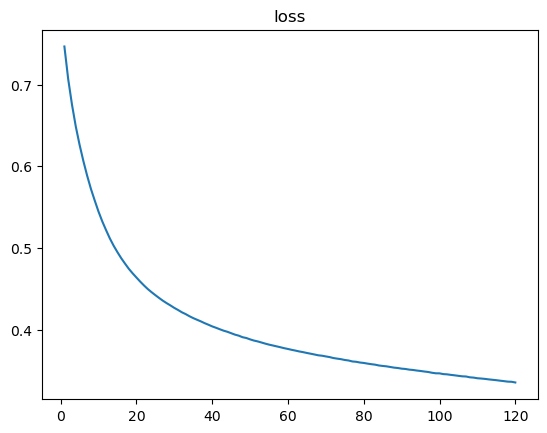

In [28]:
%matplotlib inline
# view loss function
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df['loss'].plot(title="loss")

In [29]:
y_pred = nn.predict(X_test_scaled)
y_pred[0:10]

8/8 [==============================] - 0s 3ms/step


array([[0.82974064],
       [0.01120505],
       [0.8036565 ],
       [0.35276955],
       [0.0113897 ],
       [0.3855844 ],
       [0.07883751],
       [0.3943725 ],
       [0.36620545],
       [0.05066342]], dtype=float32)

In [30]:
# save model
nn.save("trained_a.h5")

#### Step 5: Optimize

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#model-optimization-and-keras-tuner